# CLUSTERS

In [1]:
import numpy as np
import datetime
from datetime import date
import json
import pylab
import pandas as pd
import matplotlib.pyplot as plt
import os, sys

### Cargando datos

In [2]:

def leer_data():
    outfile='./SOURCES/data.csv'
    data = pd.read_csv(outfile)
    return data

data_original = leer_data()
data_original.head(3)

,client_id,date,año,mes,dia,hora,merchant_departement,merchant_province,merchant_district,mcc,mccg,client_age,quantity,amount_sol,dia_semana,turno
0,NNeQwQy9MAQ=,2016-07-15 22:23:25,2016,7,15,22,LIMA,LIMA,San Juan De Luriganc,7994,2,33.0,1,100.0,Fri,4-Noche
1,qFRoPHPOc/I=,2016-06-21 21:30:55,2016,6,21,21,LIMA,LIMA,San Juan De Luriganc,7994,2,52.0,1,20.0,Tues,4-Noche
2,qFRoPHPOc/I=,2017-02-01 01:29:59,2017,2,1,1,LIMA,LIMA,San Juan De Luriganc,7994,2,52.0,1,100.0,Weds,1-Madrugada


### Preparacion de datos

In [3]:
data = data_original[['client_id','mccg','date','año','mes','dia','hora','quantity','amount_sol']]
data.head(5) 

,client_id,mccg,date,año,mes,dia,hora,quantity,amount_sol
0,NNeQwQy9MAQ=,2,2016-07-15 22:23:25,2016,7,15,22,1,100.0
1,qFRoPHPOc/I=,2,2016-06-21 21:30:55,2016,6,21,21,1,20.0
2,qFRoPHPOc/I=,2,2017-02-01 01:29:59,2017,2,1,1,1,100.0
3,qFRoPHPOc/I=,2,2017-03-09 02:26:05,2017,3,9,2,1,50.0
4,he9pUcExpTY=,2,2016-10-01 06:45:48,2016,10,1,6,1,100.0


### Definimos los MCCG de esta data

In [4]:
mccgs = data.groupby(['mccg']).min().index.values

title = ''
for i in range(len(mccgs)):
    for j in range(4):            # numero de turnos
        for k in range(7):            # numero de dias
            title = title+';'+'m'+str(mccgs[i])+'t'+str(j)+'d'+str(k)
title = title+'\n'
mccgs,title

(array([2, 3, 4, 5]),
 ';m2t0d0;m2t0d1;m2t0d2;m2t0d3;m2t0d4;m2t0d5;m2t0d6;m2t1d0;m2t1d1;m2t1d2;m2t1d3;m2t1d4;m2t1d5;m2t1d6;m2t2d0;m2t2d1;m2t2d2;m2t2d3;m2t2d4;m2t2d5;m2t2d6;m2t3d0;m2t3d1;m2t3d2;m2t3d3;m2t3d4;m2t3d5;m2t3d6;m3t0d0;m3t0d1;m3t0d2;m3t0d3;m3t0d4;m3t0d5;m3t0d6;m3t1d0;m3t1d1;m3t1d2;m3t1d3;m3t1d4;m3t1d5;m3t1d6;m3t2d0;m3t2d1;m3t2d2;m3t2d3;m3t2d4;m3t2d5;m3t2d6;m3t3d0;m3t3d1;m3t3d2;m3t3d3;m3t3d4;m3t3d5;m3t3d6;m4t0d0;m4t0d1;m4t0d2;m4t0d3;m4t0d4;m4t0d5;m4t0d6;m4t1d0;m4t1d1;m4t1d2;m4t1d3;m4t1d4;m4t1d5;m4t1d6;m4t2d0;m4t2d1;m4t2d2;m4t2d3;m4t2d4;m4t2d5;m4t2d6;m4t3d0;m4t3d1;m4t3d2;m4t3d3;m4t3d4;m4t3d5;m4t3d6;m5t0d0;m5t0d1;m5t0d2;m5t0d3;m5t0d4;m5t0d5;m5t0d6;m5t1d0;m5t1d1;m5t1d2;m5t1d3;m5t1d4;m5t1d5;m5t1d6;m5t2d0;m5t2d1;m5t2d2;m5t2d3;m5t2d4;m5t2d5;m5t2d6;m5t3d0;m5t3d1;m5t3d2;m5t3d3;m5t3d4;m5t3d5;m5t3d6\n')

## Funciones de Apoyo (clusters)

In [5]:
def process_footprint(data,tests,log=False):
    from sklearn.cluster import MiniBatchKMeans
    #KMeans(init='k-means++', n_clusters=k, n_init=10)
    import datetime
    K={}
    for k in tests:
        if k<=len(data):
            if log:
                print("%s: processing %s"%(datetime.datetime.now(),k))
            K[k]=bench_k_means(MiniBatchKMeans(init='k-means++', n_clusters=k, batch_size=100,
                      n_init=10, max_no_improvement=10, verbose=0,
                      random_state=0),name="k-means++", data=data)
    return K

In [6]:
def compute_best_k(x,y,occurrencies, plot=False,points=1000,sf=0.9):
    import numpy as np
    
    if len(x)<5:
        b_k = max(1, round(np.sqrt(occurrencies/2)))
        if plot:
            import pylab
            pylab.plot(x,y)
            pylab.scatter(x[b_k],y[b_k],s=20, marker='o')
            pylab.text(x[b_k],y[b_k],"bestK %s" %(b_k))
            return b_k,pylab

        return b_k
    
    from scipy.interpolate import interp1d
    from scipy.interpolate import UnivariateSpline
    spl = UnivariateSpline(x, y)
    spl.set_smoothing_factor(sf)
    xs = np.linspace(min(x), max(x), points)
    ys = spl(xs)
    idx_better_k=get_change_point(xs, ys)
    if plot:
        import pylab
        pylab.plot(xs,ys)
        
        pylab.scatter(xs[idx_better_k],ys[idx_better_k],s=20, marker='o')
        pylab.text(xs[idx_better_k],ys[idx_better_k],"bestK %s" %(np.round(xs[idx_better_k])))
        return int(np.round(xs[idx_better_k])),pylab
    return int(np.round(xs[idx_better_k]))

In [7]:
def bench_k_means(estimator, name, data,distance_function=None):
    from sklearn import metrics
    from sklearn.metrics import silhouette_samples, silhouette_score
    import time
    t0 = time.time()
    if distance_function:
        estimator.fit(data,distance_function)
    else:
        estimator.fit(data)
    #cluster_labels = estimator.fit_predict(data)
    #silhouette_score_ = silhouette_score(data, cluster_labels)
    
    inertia=estimator.inertia_
    duration=time.time() - t0
    return {'inertia':inertia,'duration':duration, 'estimator':estimator}#,'silhouette':silhouette_score_}

def get_change_point(x, y):
    """
         Elección del mejor K
         :: param x: lista de valores de K
         :: param y: lista de valores de SSE
    """
    import math
    max_d = -float('infinity')
    index = 0

    for i in range(0, len(x)):
        c = closest_point_on_segment(a=[x[0], y[0]], b=[x[len(x)-1], y[len(y)-1]], p=[x[i], y[i]])
        d = math.sqrt((c[0]-x[i])**2 + (c[1]-y[i])**2)
        if d > max_d:
            max_d = d
            index = i
    
    return index

def closest_point_on_segment(a, b, p):
    sx1 = a[0]
    sx2 = b[0]
    sy1 = a[1]
    sy2 = b[1]
    px = p[0]
    py = p[1]

    x_delta = sx2 - sx1
    y_delta = sy2 - sy1

    if x_delta == 0 and y_delta == 0:
        return p

    u = ((px - sx1) * x_delta + (py - sy1) * y_delta) / (x_delta * x_delta + y_delta *  y_delta)
    if u < 0:
        closest_point = a
    elif u > 1:
        closest_point = b
    else:
        cp_x = sx1 + u * x_delta
        cp_y = sy1 + u * y_delta
        closest_point = [cp_x, cp_y]

    return closest_point
	

# Clusters Individuales (f)

In [8]:
"""# Extraemos la lista de clientes sin repetir

def leer_data(outfile):
    data = pd.read_csv(outfile)
    return data"""

'# Extraemos la lista de clientes sin repetir\n\ndef leer_data(outfile):\n    data = pd.read_csv(outfile)\n    return data'

In [9]:
file='./RESULTS/U' 

footprint="%s.footprint" %(file)
individual_clusters="%s.individual_footprint.clusters" %(file)
individual_labels="%s.individual_footprint.labels" %(file)   

# Extraemos la lista de clientes sin repetir
data_temp = pd.read_csv(footprint)
clientes =  data_temp.groupby('customer_id').customer_id.count().index
    
# Numero de filas del archivo
f=open(footprint)
num_rows = len(f.readlines())-1
f.close()

#<customer_id;year;week;profile_id;size;t1... tn >
import datetime
f=open(footprint)
fw=open(individual_clusters,'w')  #uid,cluster_id,centroid
fw2=open(individual_labels,'w') #uid,year,week,cluster_id,profile
fw.write('customer_tag;individual_cluster'+title)
fw2.write('customer_tag;year;week;individual_cluster'+title)

f.readline()
data=[] #buffer

footprints_clustered=0
footprints_clusters=0
n_cliente=0
contador = 0
temporal= 0
for row in f: #reading individual footprint
    row=row.strip().split(',') # leemos cada elemento da linea parseada por ","
    uid=row[0]
    year=row[1]
    week=row[2]
    size=float(row[6])
    profile=np.array([float(el) for el in row[7:]])
    # Individual clustering
    if uid==clientes[n_cliente]: # Para cada fila donde los "uid" son iguales 
        data.append(((uid,year,week),profile))     
        contador+=1
    else: #final de cliente
        #---------------------------------------------------------------------
        # procesar data
        #---------------------------------------------------------------------
        to_cluster=[el[1] for el in data]
        K=process_footprint(to_cluster,np.arange(1,len(to_cluster)+1))

        # choose k
        x=list(K.keys())
        y=[K[k]['inertia'] for k in K]
        best_k=compute_best_k(x,y,len(to_cluster))
        print(str(contador)+' => clustering: '+str(clientes[n_cliente])+' len data: '+str(len(data))+" best k: "+str(best_k))

        # clustering
        if best_k==1:
            #to few records
            cluster_centers_=[np.average(to_cluster,axis=0)]
            labels_=[0]*len(to_cluster)  
        else:
            cluster_centers_=K[best_k]['estimator'].cluster_centers_
            labels_=K[best_k]['estimator'].labels_

        #export individual centroids
        for i in np.arange(len(cluster_centers_)):
            string="%s;%s;%s\n"%(clientes[n_cliente],i,';'.join([str(el) for el in cluster_centers_[i]])) #uid,cluster_id,centroid
            fw.write(string)
            footprints_clusters+=1
        fw.flush()

        #export original data and labels
        for i in np.arange(len(data)):
            uid2=data[i][0]
            profile2=data[i][1]
            label2=labels_[i]
            string="%s;%s;%s;%s;%s\n" %(uid2[0],uid2[1],uid2[2],label2
                                                        ,';'.join([str(el) for el in profile2]))#uid,year,week,cluster_id,profile
            fw2.write(string)
            footprints_clustered+=1
        fw2.flush()
        #---------------------------------------------------------------------
        #---------------------------------------------------------------------



        data=[] #buffer
        data.append(((uid,year,week),profile))

        contador+=1
        temporal+=1
        n_cliente+=1

    if contador == num_rows:        # Para el ultimo cliente y ultima fila
        #---------------------------------------------------------------------
        # procesar data
        #---------------------------------------------------------------------
        to_cluster=[el[1] for el in data]
        K=process_footprint(to_cluster,np.arange(1,len(to_cluster)+1))

        # choose k
        x=list(K.keys())
        y=[K[k]['inertia'] for k in K]
        best_k=compute_best_k(x,y,len(to_cluster))
        print(str(contador)+' => clustering: '+str(clientes[n_cliente])+' len data: '+str(len(data))+" best k: "+str(best_k))

        # clustering
        if best_k==1:
            #to few records
            cluster_centers_=[np.average(to_cluster,axis=0)]
            labels_=[0]*len(to_cluster)  
        else:
            cluster_centers_=K[best_k]['estimator'].cluster_centers_
            labels_=K[best_k]['estimator'].labels_

        #export individual centroids
        for i in np.arange(len(cluster_centers_)):
            string="%s;%s;%s\n"%(uid,i,';'.join([str(el) for el in cluster_centers_[i]])) #uid,cluster_id,centroid
            fw.write(string)
            footprints_clusters+=1
        fw.flush()

        #export original data and labels
        for i in np.arange(len(data)):
            uid2=data[i][0]
            profile2=data[i][1]
            label2=labels_[i]
            string="%s;%s;%s;%s;%s\n" %(uid2[0],uid2[1],uid2[2],label2
                                                        ,';'.join([str(el) for el in profile2]))#uid,year,week,cluster_id,profile
            fw2.write(string)
            footprints_clustered+=1
        fw2.flush()
        #---------------------------------------------------------------------
        #---------------------------------------------------------------------


            
print('Done')            
    

1 => clustering: +9yJoBsAES4= len data: 1 best k: 1
2 => clustering: +EUZmfQX5bA= len data: 1 best k: 1
7 => clustering: +Ilmh+mr2WM= len data: 5 best k: 3
13 => clustering: +JHjmW4a+e0= len data: 6 best k: 3
15 => clustering: +JcXo4zlmNQ= len data: 2 best k: 1
16 => clustering: +LuVUb5tUBg= len data: 1 best k: 1
17 => clustering: +MD+jHUjjBs= len data: 1 best k: 1
18 => clustering: +P5K869BYbE= len data: 1 best k: 1
19 => clustering: +PAlAt5GZNg= len data: 1 best k: 1
20 => clustering: +PJntcDJ/w0= len data: 1 best k: 1
21 => clustering: +POZVSUf9pI= len data: 1 best k: 1
23 => clustering: +PREZ3ccYyY= len data: 2 best k: 1
24 => clustering: +PSxsw+5694= len data: 1 best k: 1
25 => clustering: +PcEhe2/a3M= len data: 1 best k: 1
27 => clustering: +PeBQTNysYs= len data: 2 best k: 1
28 => clustering: +QSSr10KkNY= len data: 1 best k: 1
31 => clustering: +QhRFlN5pIw= len data: 3 best k: 1
32 => clustering: +QobdaYlxpc= len data: 1 best k: 1
33 => clustering: +RVikwwl1SQ= len data: 1 best k

279 => clustering: /iAtgptD1jQ= len data: 3 best k: 1
280 => clustering: /ihR1x/vyDo= len data: 1 best k: 1
281 => clustering: /j5447Y4lEE= len data: 1 best k: 1
282 => clustering: /jOOoxa4qaA= len data: 1 best k: 1
283 => clustering: /jVDihMF9Kg= len data: 1 best k: 1
285 => clustering: /jWnK2ZQWhU= len data: 2 best k: 1
286 => clustering: /k0bI3/M61M= len data: 1 best k: 1
287 => clustering: /kI8/bQZXDU= len data: 1 best k: 1
289 => clustering: /kUpYwQ4Y0k= len data: 2 best k: 1
295 => clustering: /kZWjw+FT0A= len data: 6 best k: 3
296 => clustering: /klEoKqpAcY= len data: 1 best k: 1
298 => clustering: /l2Vu7jV4f4= len data: 2 best k: 1
299 => clustering: /m+58UXBUnw= len data: 1 best k: 1
300 => clustering: /mWwADBtpEk= len data: 1 best k: 1
302 => clustering: /me37v2KZG8= len data: 2 best k: 1
307 => clustering: /mh6+uNUXW8= len data: 5 best k: 4
308 => clustering: /oPESSanHnA= len data: 1 best k: 1
309 => clustering: /oT9RydHAp4= len data: 1 best k: 1
310 => clustering: /oh2Ywa0M

524 => clustering: 0qbLeowpic8= len data: 8 best k: 6
526 => clustering: 0rP1nJyA0Hg= len data: 2 best k: 1
527 => clustering: 0rqeKFrGVbA= len data: 1 best k: 1
529 => clustering: 0rsOeS9kU+4= len data: 2 best k: 1
530 => clustering: 0rvNrbBA1dw= len data: 1 best k: 1
531 => clustering: 0rvh1eA167M= len data: 1 best k: 1
532 => clustering: 0sOrnd+q0pg= len data: 1 best k: 1
537 => clustering: 0sUwk5EL+G8= len data: 5 best k: 2
538 => clustering: 0svH0BsUVGo= len data: 1 best k: 1
541 => clustering: 0tVuD+tzlJw= len data: 3 best k: 1
544 => clustering: 0vDCsp+jUL0= len data: 3 best k: 1
545 => clustering: 0vYaU7D5pMQ= len data: 1 best k: 1
546 => clustering: 0waDiccT0hE= len data: 1 best k: 1
548 => clustering: 0xEiSBqTE18= len data: 2 best k: 1
549 => clustering: 0xc3H9sD9bU= len data: 1 best k: 1
552 => clustering: 0xfQ0I5nZ/U= len data: 3 best k: 1
553 => clustering: 0yy5Dq9bSHE= len data: 1 best k: 1
554 => clustering: 0zJDFajDxBY= len data: 1 best k: 1
555 => clustering: 0zUKC+KY8

760 => clustering: 21rtFMBFKbI= len data: 7 best k: 3
761 => clustering: 22kbXbPlNc0= len data: 1 best k: 1
762 => clustering: 235blj6dVig= len data: 1 best k: 1
763 => clustering: 23iAFJ/XcwI= len data: 1 best k: 1
764 => clustering: 249QX12qRs4= len data: 1 best k: 1
765 => clustering: 24FT2OrByYM= len data: 1 best k: 1
766 => clustering: 24Tce1csyPQ= len data: 1 best k: 1
767 => clustering: 24fEVfV+5zc= len data: 1 best k: 1
768 => clustering: 25QdqIc7X4Y= len data: 1 best k: 1
770 => clustering: 25efNmivUeY= len data: 2 best k: 1
771 => clustering: 28ohP2T4WEQ= len data: 1 best k: 1
772 => clustering: 29Frc1objj8= len data: 1 best k: 1
773 => clustering: 2AEKrwXTkn0= len data: 1 best k: 1
774 => clustering: 2ANsyNdPyBs= len data: 1 best k: 1
775 => clustering: 2Bo/iVPojPo= len data: 1 best k: 1
777 => clustering: 2C2pAGn+guU= len data: 2 best k: 1
778 => clustering: 2CV82aGKlTg= len data: 1 best k: 1
780 => clustering: 2DAIgzNv6dY= len data: 2 best k: 1
781 => clustering: 2DCt6Bt3C

989 => clustering: 3KLuOLj2kjc= len data: 2 best k: 1
991 => clustering: 3KWQTlgs/xM= len data: 2 best k: 1
992 => clustering: 3KxO+XOrSuM= len data: 1 best k: 1
994 => clustering: 3L31SaKC+sk= len data: 2 best k: 1
995 => clustering: 3LXaxcj5PCA= len data: 1 best k: 1
996 => clustering: 3Lhi5MHtWDg= len data: 1 best k: 1
997 => clustering: 3MD66ujxu1Y= len data: 1 best k: 1
998 => clustering: 3MFhR52fZiU= len data: 1 best k: 1
999 => clustering: 3MIc//InCbw= len data: 1 best k: 1
1000 => clustering: 3Mcm46cHE3E= len data: 1 best k: 1
1001 => clustering: 3NKGdu8pgnI= len data: 1 best k: 1
1002 => clustering: 3NjZJAIm9+Q= len data: 1 best k: 1
1003 => clustering: 3OQCTC/9Z5c= len data: 1 best k: 1
1004 => clustering: 3P4mrQRgz/A= len data: 1 best k: 1
1005 => clustering: 3PA+ZxcGezQ= len data: 1 best k: 1
1006 => clustering: 3PJX4/4z0Og= len data: 1 best k: 1
1007 => clustering: 3PfqV0Vgqc4= len data: 1 best k: 1
1008 => clustering: 3QM6GMY+VyQ= len data: 1 best k: 1
1009 => clustering:

1217 => clustering: 4NchNk70LkY= len data: 10 best k: 5
1218 => clustering: 4Nkyu6UvTt4= len data: 1 best k: 1
1219 => clustering: 4P5Milfm0mo= len data: 1 best k: 1
1221 => clustering: 4PRqi/ehYOM= len data: 2 best k: 1
1223 => clustering: 4PWgzykZb2I= len data: 2 best k: 1
1224 => clustering: 4PqOoPzMF0I= len data: 1 best k: 1
1225 => clustering: 4PxmGM7KkD0= len data: 1 best k: 1
1227 => clustering: 4Q5vjYx/g4E= len data: 2 best k: 1
1228 => clustering: 4Qtwg0IBCt8= len data: 1 best k: 1
1229 => clustering: 4QuNGSsDsMw= len data: 1 best k: 1
1230 => clustering: 4RhD02M9PgA= len data: 1 best k: 1
1234 => clustering: 4TJMU84xpuk= len data: 4 best k: 1
1235 => clustering: 4UJi5GATqdE= len data: 1 best k: 1
1237 => clustering: 4VUK729cOGs= len data: 2 best k: 1
1238 => clustering: 4VgZiU6ywuc= len data: 1 best k: 1
1240 => clustering: 4VtorFAkkko= len data: 2 best k: 1
1241 => clustering: 4WS9r6/eS8A= len data: 1 best k: 1
1243 => clustering: 4WqKr+WC1VE= len data: 2 best k: 1
1244 => c

1465 => clustering: 5g4ARcKEX2s= len data: 3 best k: 1
1466 => clustering: 5g8+Urtv17g= len data: 1 best k: 1
1467 => clustering: 5h8OOoKYk3M= len data: 1 best k: 1
1468 => clustering: 5hCufl+mOjk= len data: 1 best k: 1
1469 => clustering: 5hc4Nh4OXsE= len data: 1 best k: 1
1470 => clustering: 5iPUKhWDosg= len data: 1 best k: 1
1471 => clustering: 5idjTmEmxLc= len data: 1 best k: 1
1472 => clustering: 5j29lcUnQHE= len data: 1 best k: 1
1474 => clustering: 5j4DknsvEKk= len data: 2 best k: 1
1476 => clustering: 5j7Q8JDyELI= len data: 2 best k: 1
1477 => clustering: 5jbXmGy+W10= len data: 1 best k: 1
1480 => clustering: 5kkIbPmEosw= len data: 3 best k: 1
1481 => clustering: 5ksjjQG1jrw= len data: 1 best k: 1
1482 => clustering: 5lPH0Tf2bq4= len data: 1 best k: 1
1484 => clustering: 5mFMliRwK2U= len data: 2 best k: 1
1487 => clustering: 5maSmNX2FIo= len data: 3 best k: 1
1500 => clustering: 5nMTJEWbIo0= len data: 13 best k: 5
1501 => clustering: 5nQKslLK7Q4= len data: 1 best k: 1
1502 => c

1702 => clustering: 6sZvyWSENfE= len data: 5 best k: 4
1703 => clustering: 6sm5HoTu4d4= len data: 1 best k: 1
1704 => clustering: 6syFft7uySY= len data: 1 best k: 1
1705 => clustering: 6tMiW0eOTsM= len data: 1 best k: 1
1706 => clustering: 6teuW39XcOM= len data: 1 best k: 1
1707 => clustering: 6utG+1zOQLE= len data: 1 best k: 1
1708 => clustering: 6uznFEiDpvE= len data: 1 best k: 1
1709 => clustering: 6vBtTotdgZs= len data: 1 best k: 1
1710 => clustering: 6vMfsCv9gxM= len data: 1 best k: 1
1711 => clustering: 6viGZaVCKVk= len data: 1 best k: 1
1716 => clustering: 6wEchoUi/eE= len data: 5 best k: 3
1717 => clustering: 6wuR/ZhlzdM= len data: 1 best k: 1
1720 => clustering: 6xZaNb//opk= len data: 3 best k: 1
1723 => clustering: 6yONmF16C6E= len data: 3 best k: 1
1724 => clustering: 6zTzdPCvOgs= len data: 1 best k: 1
1727 => clustering: 6zcpxJUB0j8= len data: 3 best k: 1
1728 => clustering: 6zj03++GB6M= len data: 1 best k: 1
1729 => clustering: 6znP1JQIIJc= len data: 1 best k: 1
1730 => cl

1933 => clustering: 81ZjLiP+HxM= len data: 2 best k: 1
1934 => clustering: 824AmahVUkk= len data: 1 best k: 1
1935 => clustering: 827d+yjEYaE= len data: 1 best k: 1
1936 => clustering: 83I73lLNjpw= len data: 1 best k: 1
1940 => clustering: 845kyLLbU/c= len data: 4 best k: 1
1941 => clustering: 84Fx9KdKoP8= len data: 1 best k: 1
1944 => clustering: 84eIkPmEXZg= len data: 3 best k: 1
1945 => clustering: 84gvMMW98Fw= len data: 1 best k: 1
1947 => clustering: 84oo8+9kwhg= len data: 2 best k: 1
1950 => clustering: 85ySzzr56GY= len data: 3 best k: 1
1953 => clustering: 86G07cu1Zz0= len data: 3 best k: 1
1956 => clustering: 86zK8kpzqno= len data: 3 best k: 1
1958 => clustering: 87OioICiAJM= len data: 2 best k: 1
1960 => clustering: 88TIKhSiBAI= len data: 2 best k: 1
1961 => clustering: 899pgnGtN4s= len data: 1 best k: 1
1962 => clustering: 89wZjzsjzDk= len data: 1 best k: 1
1963 => clustering: 8A9CZDwtRsU= len data: 1 best k: 1
1964 => clustering: 8BDhocdMZSs= len data: 1 best k: 1
1966 => cl

2171 => clustering: 9G7e6QP3E8c= len data: 1 best k: 1
2172 => clustering: 9G9o6dA98H8= len data: 1 best k: 1
2175 => clustering: 9GyGmVeoKJM= len data: 3 best k: 1
2177 => clustering: 9IJsZUjDGGw= len data: 2 best k: 1
2178 => clustering: 9IhNI714h7M= len data: 1 best k: 1
2179 => clustering: 9JCvkcSCmPY= len data: 1 best k: 1
2180 => clustering: 9Jn3kmmhhg8= len data: 1 best k: 1
2182 => clustering: 9KElhzO2/uw= len data: 2 best k: 1
2184 => clustering: 9KHSZ/zfcjk= len data: 2 best k: 1
2185 => clustering: 9LOTpJSBbSk= len data: 1 best k: 1
2187 => clustering: 9LVwcWS7sck= len data: 2 best k: 1
2191 => clustering: 9LpNrFB/KNQ= len data: 4 best k: 1
2192 => clustering: 9Mb1snrlycs= len data: 1 best k: 1
2193 => clustering: 9NEE3jZ37ww= len data: 1 best k: 1
2194 => clustering: 9NwqLAi5YNM= len data: 1 best k: 1
2195 => clustering: 9OA0KCH9BPQ= len data: 1 best k: 1
2196 => clustering: 9OG3LSbm8H8= len data: 1 best k: 1
2197 => clustering: 9ORA61k4WjQ= len data: 1 best k: 1
2198 => cl

2423 => clustering: AWYMS2p2ZN4= len data: 3 best k: 1
2424 => clustering: AWsWEtPJ3f4= len data: 1 best k: 1
2425 => clustering: AXG2SvVvXEI= len data: 1 best k: 1
2426 => clustering: AXNKvAPLbAw= len data: 1 best k: 1
2428 => clustering: AYoUjoHcJkg= len data: 2 best k: 1
2430 => clustering: AYsXt1PEBQU= len data: 2 best k: 1
2431 => clustering: AYxNy3d0g9s= len data: 1 best k: 1
2433 => clustering: AZB8OMPgwzM= len data: 2 best k: 1
2434 => clustering: AZqLwS6+0fs= len data: 1 best k: 1
2435 => clustering: AaNEzNu6LoU= len data: 1 best k: 1
2436 => clustering: AbOqjmLkrEY= len data: 1 best k: 1
2437 => clustering: AbYbuNL+0C8= len data: 1 best k: 1
2438 => clustering: AcWA0lwXPNo= len data: 1 best k: 1
2439 => clustering: Ad+RyuetxGo= len data: 1 best k: 1
2440 => clustering: Ad984y3bLZY= len data: 1 best k: 1
2441 => clustering: AdgIqSApyJE= len data: 1 best k: 1
2442 => clustering: AeDYc/Zoi6M= len data: 1 best k: 1
2443 => clustering: AePqj1l2KdQ= len data: 1 best k: 1
2444 => cl

2671 => clustering: Bo/oHMjLCSg= len data: 1 best k: 1
2672 => clustering: BoXTpmQR60o= len data: 1 best k: 1
2677 => clustering: BqUKpGwITXs= len data: 5 best k: 2
2681 => clustering: BrJGZwaVOPQ= len data: 4 best k: 1
2682 => clustering: BsZ/npigZpg= len data: 1 best k: 1
2683 => clustering: BtpR5LBqd7c= len data: 1 best k: 1
2684 => clustering: Btv7IOT/vqo= len data: 1 best k: 1
2685 => clustering: BuhPabMwvpY= len data: 1 best k: 1
2686 => clustering: Bulkbiu8iKA= len data: 1 best k: 1
2688 => clustering: Bum8wRRplRQ= len data: 2 best k: 1
2689 => clustering: BupHrNpWFW8= len data: 1 best k: 1
2694 => clustering: BvOb02D94Nc= len data: 5 best k: 2
2695 => clustering: Bvive9PfCI8= len data: 1 best k: 1
2696 => clustering: Bw03I9hXUUk= len data: 1 best k: 1
2697 => clustering: Bw9VCbYPfjA= len data: 1 best k: 1
2698 => clustering: BwKmbXupqnE= len data: 1 best k: 1
2699 => clustering: BxsUK3w0pGs= len data: 1 best k: 1
2700 => clustering: ByvTeVDSbCA= len data: 1 best k: 1
2701 => cl

2914 => clustering: D+Nop0AfR2I= len data: 17 best k: 8
2915 => clustering: D+ZighsDctc= len data: 1 best k: 1
2916 => clustering: D/372pENthA= len data: 1 best k: 1
2917 => clustering: D/Ay1XhXNEQ= len data: 1 best k: 1
2919 => clustering: D/OlcCYyyvk= len data: 2 best k: 1
2930 => clustering: D/Vq8tJiQwQ= len data: 11 best k: 5
2931 => clustering: D0mcsYA+kXw= len data: 1 best k: 1
2932 => clustering: D0rH/HNodmk= len data: 1 best k: 1
2933 => clustering: D0slN8xkUTo= len data: 1 best k: 1
2934 => clustering: D1+thnjmMiA= len data: 1 best k: 1
2935 => clustering: D14X59GtS9U= len data: 1 best k: 1
2936 => clustering: D24SJCnYBLo= len data: 1 best k: 1
2937 => clustering: D3G8Qs49KtU= len data: 1 best k: 1
2939 => clustering: D4WuHOP3Bd4= len data: 2 best k: 1
2941 => clustering: D5/eD60qmgg= len data: 2 best k: 1
2942 => clustering: D5a7N4NtLuM= len data: 1 best k: 1
2943 => clustering: D5aquuWUin0= len data: 1 best k: 1
2944 => clustering: D6AMjkcp/jg= len data: 1 best k: 1
2945 => 

3234 => clustering: EEtL4bh0170= len data: 1 best k: 1
3235 => clustering: EFW4DyxA1kk= len data: 1 best k: 1
3236 => clustering: EGPNzZUaygM= len data: 1 best k: 1
3238 => clustering: EIGhJsITYus= len data: 2 best k: 1
3239 => clustering: EIN2AdCs5Ng= len data: 1 best k: 1
3240 => clustering: EIQtD2kW3ko= len data: 1 best k: 1
3242 => clustering: EIV09+ba0mA= len data: 2 best k: 1
3243 => clustering: EJ1tJUjse6k= len data: 1 best k: 1
3244 => clustering: EJegYB0XogU= len data: 1 best k: 1
3245 => clustering: EKkfEoUicQw= len data: 1 best k: 1
3246 => clustering: EKnwZJ4rBt4= len data: 1 best k: 1
3247 => clustering: EKyH1L/8HW0= len data: 1 best k: 1
3248 => clustering: EMqD8Xcdngc= len data: 1 best k: 1
3251 => clustering: ENKqIIxTQkw= len data: 3 best k: 1
3252 => clustering: EOiX2GCQvBs= len data: 1 best k: 1
3253 => clustering: EP3ztfBqhRg= len data: 1 best k: 1
3254 => clustering: EPGWwZeW5v4= len data: 1 best k: 1
3255 => clustering: EPRSiZMRhIU= len data: 1 best k: 1
3256 => cl

3494 => clustering: FeF5ecq58sM= len data: 15 best k: 5
3495 => clustering: FeFvp2K+aOQ= len data: 1 best k: 1
3496 => clustering: FeZYjdO9PT0= len data: 1 best k: 1
3499 => clustering: FeoG7d7gzaU= len data: 3 best k: 1
3500 => clustering: Ff0D03F5rRw= len data: 1 best k: 1
3501 => clustering: FfN0/XQHKb8= len data: 1 best k: 1
3502 => clustering: FfUgWiP/A/s= len data: 1 best k: 1
3503 => clustering: FfjOVNUj4GY= len data: 1 best k: 1
3506 => clustering: Fgl/UbiSLLY= len data: 3 best k: 1
3509 => clustering: FgroRPVIUn4= len data: 3 best k: 1
3510 => clustering: FgyAkDggVMI= len data: 1 best k: 1
3511 => clustering: Fh/jT9usHi8= len data: 1 best k: 1
3512 => clustering: FhKhOtEiqts= len data: 1 best k: 1
3513 => clustering: FhbXIhocsCE= len data: 1 best k: 1
3517 => clustering: Fhwn8EAnQIM= len data: 4 best k: 1
3518 => clustering: Fhx68uiATgM= len data: 1 best k: 1
3519 => clustering: Fi9IDtAcrEw= len data: 1 best k: 1
3520 => clustering: Fit26VjvJGQ= len data: 1 best k: 1
3529 => c

3728 => clustering: Gmxo46SSb08= len data: 1 best k: 1
3730 => clustering: GnlDA+O0x6M= len data: 2 best k: 1
3731 => clustering: GozXKclPxrA= len data: 1 best k: 1
3732 => clustering: GpCBq9DKkyk= len data: 1 best k: 1
3733 => clustering: GpMXRA7c/3c= len data: 1 best k: 1
3734 => clustering: GqnVmEhYGlk= len data: 1 best k: 1
3735 => clustering: GsgLdhNYqTY= len data: 1 best k: 1
3736 => clustering: GtO6Uk8F4gE= len data: 1 best k: 1
3737 => clustering: GuBodyQ84Sk= len data: 1 best k: 1
3738 => clustering: GuQ8Er7vw2I= len data: 1 best k: 1
3741 => clustering: GuiegBX1D5I= len data: 3 best k: 1
3742 => clustering: GuoX8uOrAKE= len data: 1 best k: 1
3743 => clustering: GvCakLAAJbI= len data: 1 best k: 1
3745 => clustering: GvI6TOJjKNQ= len data: 2 best k: 1
3746 => clustering: GvSaOPDk2js= len data: 1 best k: 1
3747 => clustering: GvXygzSdA08= len data: 1 best k: 1
3748 => clustering: GvrjDaQ+vCw= len data: 1 best k: 1
3749 => clustering: Gvt8vhSo4Yk= len data: 1 best k: 1
3751 => cl

4033 => clustering: I32gocE4SqU= len data: 1 best k: 1
4036 => clustering: I4AAxBTvMqU= len data: 3 best k: 1
4037 => clustering: I5CJjPpd8bg= len data: 1 best k: 1
4038 => clustering: I67GyHvqR2k= len data: 1 best k: 1
4040 => clustering: I7tnZ6CVN+4= len data: 2 best k: 1
4042 => clustering: I8XO4g7522Q= len data: 2 best k: 1
4045 => clustering: I9XPZMBEOOA= len data: 3 best k: 1
4046 => clustering: I9nIooGTTXE= len data: 1 best k: 1
4048 => clustering: IABP93ZyuNE= len data: 2 best k: 1
4049 => clustering: IAYMJhBlf/A= len data: 1 best k: 1
4051 => clustering: IAulRWWACbs= len data: 2 best k: 1
4053 => clustering: IB1tWN28dsQ= len data: 2 best k: 1
4054 => clustering: IBEu4o3SzuY= len data: 1 best k: 1
4055 => clustering: IBsUauOkimo= len data: 1 best k: 1
4056 => clustering: IC/3ubCxWHE= len data: 1 best k: 1
4057 => clustering: ICH0DsQc+h8= len data: 1 best k: 1
4058 => clustering: IDFRlbO9lio= len data: 1 best k: 1
4059 => clustering: IDMK9w0P5xs= len data: 1 best k: 1
4060 => cl

4290 => clustering: J8dPIawTFSE= len data: 1 best k: 1
4296 => clustering: JA+E251d2+Q= len data: 6 best k: 5
4297 => clustering: JAwCZkdG0AA= len data: 1 best k: 1
4298 => clustering: JBHHjE9l0sY= len data: 1 best k: 1
4302 => clustering: JEfqf+QHwWc= len data: 4 best k: 1
4303 => clustering: JFLATo8L6yM= len data: 1 best k: 1
4304 => clustering: JG9VgA0prCk= len data: 1 best k: 1
4305 => clustering: JGHBW/aIaVQ= len data: 1 best k: 1
4307 => clustering: JHUV87AzhgA= len data: 2 best k: 1
4308 => clustering: JIYAcQc1+ss= len data: 1 best k: 1
4309 => clustering: JJ42pU37Xlg= len data: 1 best k: 1
4310 => clustering: JKUqY8iKjE8= len data: 1 best k: 1
4311 => clustering: JLM2XWCDmS0= len data: 1 best k: 1
4312 => clustering: JLiti1UAIbM= len data: 1 best k: 1
4313 => clustering: JMGq5Xazxpc= len data: 1 best k: 1
4316 => clustering: JNSiobDT/dM= len data: 3 best k: 1
4317 => clustering: JNr8TWEqGo0= len data: 1 best k: 1
4318 => clustering: JOBcqg3EKqA= len data: 1 best k: 1
4319 => cl

4529 => clustering: KhQJi+TW4NY= len data: 2 best k: 1
4532 => clustering: Khl+WYpKe50= len data: 3 best k: 1
4533 => clustering: KhsF4CiZaio= len data: 1 best k: 1
4534 => clustering: Ki/TxwzSxqw= len data: 1 best k: 1
4536 => clustering: Kidxh6G0zu8= len data: 2 best k: 1
4537 => clustering: KjBvllZMTb0= len data: 1 best k: 1
4538 => clustering: KjUi6eSN0jo= len data: 1 best k: 1
4539 => clustering: KjvOFUTl1nI= len data: 1 best k: 1
4540 => clustering: KkRMH7x1M2k= len data: 1 best k: 1
4542 => clustering: KktInp7BRHs= len data: 2 best k: 1
4544 => clustering: KlWJUktSf14= len data: 2 best k: 1
4545 => clustering: Klu/JS34S1g= len data: 1 best k: 1
4546 => clustering: KmalUjOR0D4= len data: 1 best k: 1
4548 => clustering: KnAfiA0wDp4= len data: 2 best k: 1
4549 => clustering: KnFTucWuDaE= len data: 1 best k: 1
4551 => clustering: KnPAbmFstVc= len data: 2 best k: 1
4553 => clustering: KnTEz4tgX8Q= len data: 2 best k: 1
4554 => clustering: KngbsJBGOVI= len data: 1 best k: 1
4555 => cl

4790 => clustering: LilfO39egrI= len data: 6 best k: 4
4791 => clustering: LkukPAKY/JQ= len data: 1 best k: 1
4792 => clustering: Lkv9H4890gA= len data: 1 best k: 1
4794 => clustering: LlUpNBifbCg= len data: 2 best k: 1
4795 => clustering: LnVqXAhb+wI= len data: 1 best k: 1
4796 => clustering: Lq9TIY6Tqak= len data: 1 best k: 1
4797 => clustering: Lr5CT/R8KnE= len data: 1 best k: 1
4798 => clustering: Ls/f8jeOTQs= len data: 1 best k: 1
4799 => clustering: Ls1KwnI7OVk= len data: 1 best k: 1
4800 => clustering: LsDZR8KhQco= len data: 1 best k: 1
4801 => clustering: LsUEAXH9ZPE= len data: 1 best k: 1
4802 => clustering: LtpJqf/xPuc= len data: 1 best k: 1
4803 => clustering: Lu2HIXqYdhw= len data: 1 best k: 1
4804 => clustering: LuIh+om6vvI= len data: 1 best k: 1
4805 => clustering: LuVQbkR8vrk= len data: 1 best k: 1
4809 => clustering: LuWj49UASAs= len data: 4 best k: 1
4810 => clustering: Luv91RgRg98= len data: 1 best k: 1
4811 => clustering: LvEDyEBZjnk= len data: 1 best k: 1
4812 => cl

4999 => clustering: MxUf9BH8+bQ= len data: 8 best k: 5
5000 => clustering: Mxlp3BY4Qzc= len data: 1 best k: 1
5001 => clustering: MxxCmx4cCio= len data: 1 best k: 1
5002 => clustering: MyC+BYD1kWA= len data: 1 best k: 1
5003 => clustering: MyKxy1+Q89Y= len data: 1 best k: 1
5004 => clustering: MydbPKs97Ac= len data: 1 best k: 1
5005 => clustering: Mz0Z4qn1Jxw= len data: 1 best k: 1
5012 => clustering: Mz7UAQSs3BM= len data: 7 best k: 3
5013 => clustering: N+IognymY5o= len data: 1 best k: 1
5014 => clustering: N0nRJCo1emk= len data: 1 best k: 1
5015 => clustering: N1FEBLzPfbg= len data: 1 best k: 1
5016 => clustering: N1ehkDbIfe0= len data: 1 best k: 1
5017 => clustering: N1gsT6/++YM= len data: 1 best k: 1
5018 => clustering: N278TgK/jkc= len data: 1 best k: 1
5019 => clustering: N2N9zxw0axc= len data: 1 best k: 1
5020 => clustering: N2YeQLKJM34= len data: 1 best k: 1
5021 => clustering: N3NNJwBM6sQ= len data: 1 best k: 1
5022 => clustering: N3s0uPGUdGQ= len data: 1 best k: 1
5023 => cl

5301 => clustering: R3ryHLFEHFA= len data: 1 best k: 1
5307 => clustering: R4sZ3dCeLp4= len data: 6 best k: 3
5309 => clustering: R4xGSA9f6eI= len data: 2 best k: 1
5317 => clustering: R76wsgmoTl8= len data: 8 best k: 1
5318 => clustering: R7MVZrpgW9o= len data: 1 best k: 1
5319 => clustering: R7iPzR03xIc= len data: 1 best k: 1
5320 => clustering: R7xYhxZYdsA= len data: 1 best k: 1
5321 => clustering: R8LOgoPYdB8= len data: 1 best k: 1
5322 => clustering: R8srWmXI3NU= len data: 1 best k: 1
5323 => clustering: R9fnZ0c54Rs= len data: 1 best k: 1
5325 => clustering: R9nakRSRAo0= len data: 2 best k: 1
5326 => clustering: R9oed+60GH8= len data: 1 best k: 1
5327 => clustering: RAKtKfvvEQ4= len data: 1 best k: 1
5328 => clustering: RAr4PdDDWCo= len data: 1 best k: 1
5329 => clustering: RBMFGRodxoM= len data: 1 best k: 1
5330 => clustering: RBNMvW1g+y8= len data: 1 best k: 1
5331 => clustering: RBeVxRjW7JQ= len data: 1 best k: 1
5332 => clustering: RC6Idpr7g+8= len data: 1 best k: 1
5333 => cl

5525 => clustering: STqdCFjTfgA= len data: 2 best k: 1
5527 => clustering: SUIXAaB8wxo= len data: 2 best k: 1
5529 => clustering: SUlCo9tbv64= len data: 2 best k: 1
5530 => clustering: SW/lSBVLWnM= len data: 1 best k: 1
5534 => clustering: SWXWjLvy4X0= len data: 4 best k: 1
5535 => clustering: Se5K59xi5q0= len data: 1 best k: 1
5536 => clustering: SjADe9Np6/E= len data: 1 best k: 1
5537 => clustering: SmbEQFGkD8k= len data: 1 best k: 1
5538 => clustering: Sn7Z2gjxoWs= len data: 1 best k: 1
5540 => clustering: SoUWAa4lCEY= len data: 2 best k: 1
5541 => clustering: Soi8/2R8VUA= len data: 1 best k: 1
5542 => clustering: StGOD08EPhk= len data: 1 best k: 1
5543 => clustering: SuVQSzJf/vI= len data: 1 best k: 1
5544 => clustering: SutS/t2DQ0U= len data: 1 best k: 1
5545 => clustering: SvZurBdqYJM= len data: 1 best k: 1
5547 => clustering: Sw6D+Z6BQFA= len data: 2 best k: 1
5548 => clustering: Sy1ad5IloIc= len data: 1 best k: 1
5549 => clustering: SyncLs21fSI= len data: 1 best k: 1
5550 => cl

5784 => clustering: UAK4F1QlwQ0= len data: 4 best k: 1
5787 => clustering: UAn+ygMLq78= len data: 3 best k: 1
5788 => clustering: UDTUu1xxqdE= len data: 1 best k: 1
5789 => clustering: UDzcSsOCWjg= len data: 1 best k: 1
5790 => clustering: UF7ouqbkHW4= len data: 1 best k: 1
5791 => clustering: UGtjfGNKlBw= len data: 1 best k: 1
5794 => clustering: UIavSDj2agM= len data: 3 best k: 1
5795 => clustering: UIcgJIykz78= len data: 1 best k: 1
5796 => clustering: UJ3Bzxyepxw= len data: 1 best k: 1
5797 => clustering: UK4mXRMZuuw= len data: 1 best k: 1
5799 => clustering: UKEffTpSEc8= len data: 2 best k: 1
5800 => clustering: UKEqEC8UWOY= len data: 1 best k: 1
5801 => clustering: ULZ6AZwDDBA= len data: 1 best k: 1
5802 => clustering: UN6j1ah3xUU= len data: 1 best k: 1
5803 => clustering: UO9ni7tnRh4= len data: 1 best k: 1
5807 => clustering: UOBw6T2WVFk= len data: 4 best k: 1
5808 => clustering: UPc3J+agjeo= len data: 1 best k: 1
5809 => clustering: UPzkru2hxl4= len data: 1 best k: 1
5810 => cl

6020 => clustering: VJyh4UTJoz8= len data: 1 best k: 1
6021 => clustering: VKs251dqec8= len data: 1 best k: 1
6023 => clustering: VL2ePlGVRMs= len data: 2 best k: 1
6027 => clustering: VLF+JqgNYdw= len data: 4 best k: 1
6032 => clustering: VLYAsGfuluc= len data: 5 best k: 4
6033 => clustering: VLahV5YcV0k= len data: 1 best k: 1
6034 => clustering: VLdBe3sM6aw= len data: 1 best k: 1
6035 => clustering: VLjELBphXgE= len data: 1 best k: 1
6036 => clustering: VMJ6CAmSN5Q= len data: 1 best k: 1
6039 => clustering: VMsxEyrrIJU= len data: 3 best k: 1
6041 => clustering: VN+mJnZnvaU= len data: 2 best k: 1
6042 => clustering: VNFUxne+2Cc= len data: 1 best k: 1
6043 => clustering: VOLeUrmhUAI= len data: 1 best k: 1
6044 => clustering: VOZLa/8FzFI= len data: 1 best k: 1
6046 => clustering: VOjLydU9pvw= len data: 2 best k: 1
6047 => clustering: VOvwdoswx0k= len data: 1 best k: 1
6048 => clustering: VP95ZpHaR7Y= len data: 1 best k: 1
6050 => clustering: VPjB6Hx3DH8= len data: 2 best k: 1
6051 => cl

6248 => clustering: WJRVouoDn9U= len data: 1 best k: 1
6251 => clustering: WJuDA+1qyF4= len data: 3 best k: 1
6254 => clustering: WJw3qE06SXo= len data: 3 best k: 1
6255 => clustering: WK0EvjEEVNk= len data: 1 best k: 1
6256 => clustering: WK2shUVTJ+U= len data: 1 best k: 1
6258 => clustering: WK3SrjEL6Yo= len data: 2 best k: 1
6260 => clustering: WLYrGonsBVA= len data: 2 best k: 1
6261 => clustering: WMC31Ge1A2s= len data: 1 best k: 1
6262 => clustering: WMCLlSAUVoM= len data: 1 best k: 1
6263 => clustering: WMHtOZFBiJA= len data: 1 best k: 1
6265 => clustering: WN/6rrlW91c= len data: 2 best k: 1
6266 => clustering: WNeo6konxOM= len data: 1 best k: 1
6267 => clustering: WNlBsxZoiX8= len data: 1 best k: 1
6269 => clustering: WOFoG343Pv8= len data: 2 best k: 1
6270 => clustering: WPchfO4ETqE= len data: 1 best k: 1
6285 => clustering: WPolh8EUjn4= len data: 15 best k: 6
6286 => clustering: WPpOUveZkX0= len data: 1 best k: 1
6287 => clustering: WQNhfqGAJ04= len data: 1 best k: 1
6288 => c

6520 => clustering: bjD5y84Jcco= len data: 2 best k: 1
6521 => clustering: bmHbxzeHpl4= len data: 1 best k: 1
6522 => clustering: bmvXrbsLBn0= len data: 1 best k: 1
6529 => clustering: bnNhk0XDZAk= len data: 7 best k: 2
6531 => clustering: brJDj0/fPWI= len data: 2 best k: 1
6532 => clustering: btOg/f2vUPc= len data: 1 best k: 1
6533 => clustering: c21AlRARZt4= len data: 1 best k: 1
6536 => clustering: c7yfJPKYfY8= len data: 3 best k: 1
6548 => clustering: cAaWS+UwxD4= len data: 12 best k: 1
6549 => clustering: cHwo9ZK9wrw= len data: 1 best k: 1
6552 => clustering: cHwpjQ8YR9M= len data: 3 best k: 1
6553 => clustering: cKiX3DKQTZ0= len data: 1 best k: 1
6554 => clustering: cNA3U5Bna5c= len data: 1 best k: 1
6555 => clustering: cPcqgyx8QP8= len data: 1 best k: 1
6556 => clustering: cQ5WGpH9eG8= len data: 1 best k: 1
6557 => clustering: cRvSKSEXKCc= len data: 1 best k: 1
6558 => clustering: cT+uekDe0Bs= len data: 1 best k: 1
6564 => clustering: cXgG6IinVSs= len data: 6 best k: 3
6565 => c

6747 => clustering: gItPZVSuv+8= len data: 1 best k: 1
6748 => clustering: gJ+6vSgVgHI= len data: 1 best k: 1
6749 => clustering: gJ+8p3d2i34= len data: 1 best k: 1
6750 => clustering: gJKItpEQf5M= len data: 1 best k: 1
6751 => clustering: gJNHSymTEAU= len data: 1 best k: 1
6752 => clustering: gJeCRrGWc2c= len data: 1 best k: 1
6753 => clustering: gKGYaqYPo2Q= len data: 1 best k: 1
6754 => clustering: gLQ2ls4+4hU= len data: 1 best k: 1
6755 => clustering: gMMUxBnBE1U= len data: 1 best k: 1
6757 => clustering: gMasICyrfO4= len data: 2 best k: 1
6758 => clustering: gMty3PWpqkk= len data: 1 best k: 1
6759 => clustering: gN+W58YokWM= len data: 1 best k: 1
6762 => clustering: gN7rZxTzfls= len data: 3 best k: 1
6763 => clustering: gNBXF5VpGn8= len data: 1 best k: 1
6764 => clustering: gNurMtQIf8s= len data: 1 best k: 1
6765 => clustering: gO92f4meLPc= len data: 1 best k: 1
6766 => clustering: gOFNyp/1mL8= len data: 1 best k: 1
6767 => clustering: gOYcHX81xQM= len data: 1 best k: 1
6768 => cl

6976 => clustering: hU4/Myvglwk= len data: 1 best k: 1
6980 => clustering: hUpB8WD1R1c= len data: 4 best k: 1
6981 => clustering: hVg5wOXMQNg= len data: 1 best k: 1
6982 => clustering: hVr+oEZ4Bd4= len data: 1 best k: 1
6985 => clustering: hW6oY3LEHGI= len data: 3 best k: 1
6986 => clustering: hWK4qfTrB0k= len data: 1 best k: 1
6987 => clustering: hWX6S2wMKR0= len data: 1 best k: 1
6988 => clustering: hWjHPg2bk1U= len data: 1 best k: 1
6991 => clustering: hWsgSzJObh4= len data: 3 best k: 1
6992 => clustering: hYC796NCIos= len data: 1 best k: 1
6993 => clustering: hYbBHWS/Bi0= len data: 1 best k: 1
6994 => clustering: hYiRP4PfLkc= len data: 1 best k: 1
6996 => clustering: hYlUfi0ZXlk= len data: 2 best k: 1
6997 => clustering: hYtsmTTsoe4= len data: 1 best k: 1
6998 => clustering: hYwXNe4qYyU= len data: 1 best k: 1
7000 => clustering: hZxDIeZAUnc= len data: 2 best k: 1
7002 => clustering: haICZO3+ND8= len data: 2 best k: 1
7003 => clustering: hbYJc78hV4A= len data: 1 best k: 1
7005 => cl

7204 => clustering: iqrw7yjh06E= len data: 3 best k: 1
7205 => clustering: ir2yWmaFt9U= len data: 1 best k: 1
7206 => clustering: irNzKyt9h/Y= len data: 1 best k: 1
7208 => clustering: irhZ45tzEr8= len data: 2 best k: 1
7209 => clustering: irr4kc4wZsc= len data: 1 best k: 1
7210 => clustering: isFrl+CoLy4= len data: 1 best k: 1
7211 => clustering: isVzPBrlgxQ= len data: 1 best k: 1
7212 => clustering: itLlZAFld/k= len data: 1 best k: 1
7213 => clustering: iuWB0xLW8C4= len data: 1 best k: 1
7214 => clustering: ivrbXkp33Lw= len data: 1 best k: 1
7215 => clustering: ivvFC5/BN8A= len data: 1 best k: 1
7216 => clustering: iwGa9EXSmjk= len data: 1 best k: 1
7222 => clustering: iwaanPLJExo= len data: 6 best k: 3
7224 => clustering: ix85/QLEEbw= len data: 2 best k: 1
7225 => clustering: ixQlnIABP+w= len data: 1 best k: 1
7226 => clustering: iy7H20HTIAU= len data: 1 best k: 1
7227 => clustering: iyCdqp2rzgU= len data: 1 best k: 1
7228 => clustering: iyFSK/uXNFA= len data: 1 best k: 1
7229 => cl

7435 => clustering: lqyP/lTKhYg= len data: 1 best k: 1
7436 => clustering: lrG4eFe+l2U= len data: 1 best k: 1
7438 => clustering: lsDIg+oDoaA= len data: 2 best k: 1
7439 => clustering: lscaYRMokO0= len data: 1 best k: 1
7440 => clustering: luIHJaJxeFs= len data: 1 best k: 1
7455 => clustering: lurq1TwUEnc= len data: 15 best k: 4
7456 => clustering: lvIVh87SXg4= len data: 1 best k: 1
7457 => clustering: lvg8QBysSGE= len data: 1 best k: 1
7458 => clustering: lvlVRjLpoJU= len data: 1 best k: 1
7459 => clustering: lwBZ77kpYi8= len data: 1 best k: 1
7460 => clustering: lxEQ0bH/aqY= len data: 1 best k: 1
7461 => clustering: lxS4vLoUZJI= len data: 1 best k: 1
7462 => clustering: lxt1E9bUleQ= len data: 1 best k: 1
7463 => clustering: lxv7sa/sQco= len data: 1 best k: 1
7464 => clustering: ly5SS4tqZJs= len data: 1 best k: 1
7465 => clustering: lyAsp+wg8no= len data: 1 best k: 1
7466 => clustering: lz4snxjPIsY= len data: 1 best k: 1
7467 => clustering: lzWacy0kYSg= len data: 1 best k: 1
7468 => c

7717 => clustering: mzrl+Uw/NjU= len data: 7 best k: 3
7718 => clustering: n+NX1vL/jV8= len data: 1 best k: 1
7719 => clustering: n+NvKwsWTbg= len data: 1 best k: 1
7721 => clustering: n+S+Q3vNTAY= len data: 2 best k: 1
7723 => clustering: n+XAz49uBGg= len data: 2 best k: 1
7724 => clustering: n/QHOim6jIo= len data: 1 best k: 1
7727 => clustering: n0HUe9aPivM= len data: 3 best k: 1
7728 => clustering: n0NvF57OhXw= len data: 1 best k: 1
7729 => clustering: n1cgXE1UWko= len data: 1 best k: 1
7730 => clustering: n1vFdXhMatQ= len data: 1 best k: 1
7732 => clustering: n1x8/9JgMI0= len data: 2 best k: 1
7733 => clustering: n2I+49qHHQs= len data: 1 best k: 1
7734 => clustering: n2OvD+xecdk= len data: 1 best k: 1
7735 => clustering: n2qkGhhjtVU= len data: 1 best k: 1
7737 => clustering: n2zEVM7VYW8= len data: 2 best k: 1
7738 => clustering: n3zPOXdMBmk= len data: 1 best k: 1
7739 => clustering: n4NjwfjeJ8o= len data: 1 best k: 1
7741 => clustering: n4aHnX4Y1UM= len data: 2 best k: 1
7742 => cl

7969 => clustering: o0Vv47YJTl8= len data: 1 best k: 1
7970 => clustering: o0goZHYT0eQ= len data: 1 best k: 1
7971 => clustering: o14ECjtaT8A= len data: 1 best k: 1
7972 => clustering: o17bSY8wbFE= len data: 1 best k: 1
7973 => clustering: o1JrxwJQnKE= len data: 1 best k: 1
7974 => clustering: o1UvkZmtyBs= len data: 1 best k: 1
7980 => clustering: o2P4S7fVc0o= len data: 6 best k: 4
7985 => clustering: o3Ye31KehF0= len data: 5 best k: 3
7986 => clustering: o3mYRdYr5Qc= len data: 1 best k: 1
7987 => clustering: o407Dp/BOXg= len data: 1 best k: 1
7989 => clustering: o4VQBDhccE4= len data: 2 best k: 1
7991 => clustering: o4YdN+c5aSs= len data: 2 best k: 1
7992 => clustering: o4pK1yUmPU4= len data: 1 best k: 1
7993 => clustering: o7PlDAzlXBI= len data: 1 best k: 1
7994 => clustering: o7iJMu2zH3A= len data: 1 best k: 1
7995 => clustering: o8DbnDzHyeU= len data: 1 best k: 1
7996 => clustering: o8Xf4SCLIlE= len data: 1 best k: 1
7997 => clustering: o8ZZ0oIxtYY= len data: 1 best k: 1
7999 => cl

8211 => clustering: pE7TkQSfq4o= len data: 1 best k: 1
8214 => clustering: pEZ7x9ilLT0= len data: 3 best k: 1
8215 => clustering: pEn8WF6jWUk= len data: 1 best k: 1
8216 => clustering: pEsff2MbkVs= len data: 1 best k: 1
8217 => clustering: pF1tM+hjExw= len data: 1 best k: 1
8218 => clustering: pFd2gzAyaAg= len data: 1 best k: 1
8219 => clustering: pH7gcJ+U2tg= len data: 1 best k: 1
8220 => clustering: pHpzYuhl9xM= len data: 1 best k: 1
8221 => clustering: pINhDLcVUOY= len data: 1 best k: 1
8223 => clustering: pK89Z/7SL1U= len data: 2 best k: 1
8224 => clustering: pKKShhQGyVU= len data: 1 best k: 1
8225 => clustering: pKObPbqXofY= len data: 1 best k: 1
8226 => clustering: pKSH5Yu7Z2A= len data: 1 best k: 1
8227 => clustering: pOnaEfpgFlE= len data: 1 best k: 1
8229 => clustering: pPATFwnQQ3Y= len data: 2 best k: 1
8230 => clustering: pPEmcEsDnfE= len data: 1 best k: 1
8231 => clustering: pQ2FZzTC0Sg= len data: 1 best k: 1
8232 => clustering: pQSuJhGwHJw= len data: 1 best k: 1
8234 => cl

8480 => clustering: qKtHk9khrKM= len data: 14 best k: 6
8481 => clustering: qKvVD31HCwc= len data: 1 best k: 1
8482 => clustering: qL01ULx/Xm0= len data: 1 best k: 1
8484 => clustering: qLDDSEuhpcs= len data: 2 best k: 1
8485 => clustering: qLVeKBix/30= len data: 1 best k: 1
8486 => clustering: qLbSkrMgaYI= len data: 1 best k: 1
8487 => clustering: qLjbNE+1+bg= len data: 1 best k: 1
8488 => clustering: qMFpiuVjsRk= len data: 1 best k: 1
8491 => clustering: qMOmqVi3qSw= len data: 3 best k: 1
8492 => clustering: qNlvVOytTPM= len data: 1 best k: 1
8493 => clustering: qNqRVW5Y+Vo= len data: 1 best k: 1
8494 => clustering: qNtjkPECet8= len data: 1 best k: 1
8495 => clustering: qOMfSU8oYiw= len data: 1 best k: 1
8496 => clustering: qPRo/kY5uYE= len data: 1 best k: 1
8497 => clustering: qPhFb/N9EmY= len data: 1 best k: 1
8498 => clustering: qQ6JWcAcuDo= len data: 1 best k: 1
8499 => clustering: qQcdqZ/kpYw= len data: 1 best k: 1
8500 => clustering: qR69hj3lz9U= len data: 1 best k: 1
8501 => c

8748 => clustering: rYM5eYzOzYk= len data: 8 best k: 4
8751 => clustering: rYQVxHGu0oA= len data: 3 best k: 1
8753 => clustering: rZE+FZiTZis= len data: 2 best k: 1
8754 => clustering: rZwA8BiV+OQ= len data: 1 best k: 1
8755 => clustering: raFcGbE3nXE= len data: 1 best k: 1
8756 => clustering: rajEJZ9/m5E= len data: 1 best k: 1
8757 => clustering: rbcOLpJeNws= len data: 1 best k: 1
8758 => clustering: rbu3T6hO68k= len data: 1 best k: 1
8759 => clustering: rcSwVpttJvc= len data: 1 best k: 1
8760 => clustering: rcgAiGzd6GQ= len data: 1 best k: 1
8763 => clustering: re25Zx6QHDc= len data: 3 best k: 1
8764 => clustering: re7WG7+ruhs= len data: 1 best k: 1
8765 => clustering: reTQRD2YBAw= len data: 1 best k: 1
8766 => clustering: relXu76pqbE= len data: 1 best k: 1
8768 => clustering: rf/t7bmeGUM= len data: 2 best k: 1
8770 => clustering: rfzKCRH2nJw= len data: 2 best k: 1
8771 => clustering: rg6h3GQHik4= len data: 1 best k: 1
8774 => clustering: rg8b9orCW+Q= len data: 3 best k: 1
8775 => cl

8995 => clustering: sbPz1+UMO6w= len data: 3 best k: 1
8996 => clustering: sbTi0iY8QsM= len data: 1 best k: 1
8997 => clustering: sbcU2+PeQfI= len data: 1 best k: 1
9000 => clustering: scTFF169MiI= len data: 3 best k: 1
9001 => clustering: scbUTqKk0x8= len data: 1 best k: 1
9002 => clustering: sdFakF1cXG4= len data: 1 best k: 1
9003 => clustering: sf2bs/2NqOA= len data: 1 best k: 1
9006 => clustering: sft2j7qLpL8= len data: 3 best k: 1
9007 => clustering: sgBbB1LmZzs= len data: 1 best k: 1
9009 => clustering: sgKiOFzUS3Q= len data: 2 best k: 1
9010 => clustering: shMAKVJPAfw= len data: 1 best k: 1
9011 => clustering: shpfz2W1iEk= len data: 1 best k: 1
9012 => clustering: shprUnaxV64= len data: 1 best k: 1
9013 => clustering: si/5IJ6mhCo= len data: 1 best k: 1
9014 => clustering: siH4CID/vkg= len data: 1 best k: 1
9015 => clustering: sikN+y06ZqU= len data: 1 best k: 1
9016 => clustering: sj61A3XPhJU= len data: 1 best k: 1
9018 => clustering: sj91Acxss2U= len data: 2 best k: 1
9024 => cl

9258 => clustering: tq1on1u07BA= len data: 1 best k: 1
9259 => clustering: tqFVySdgykk= len data: 1 best k: 1
9260 => clustering: trTKbJx746A= len data: 1 best k: 1
9261 => clustering: trTp54z/Y68= len data: 1 best k: 1
9262 => clustering: trfBHVDp2PA= len data: 1 best k: 1
9263 => clustering: trwdZbQ/NPo= len data: 1 best k: 1
9264 => clustering: ts4SjjORKEE= len data: 1 best k: 1
9265 => clustering: tsK2aQ+oHTY= len data: 1 best k: 1
9266 => clustering: tsbdHU56iDg= len data: 1 best k: 1
9267 => clustering: ttKHIp/6blI= len data: 1 best k: 1
9269 => clustering: tuNojotr8vQ= len data: 2 best k: 1
9270 => clustering: tvLMayjFavM= len data: 1 best k: 1
9271 => clustering: txAQmSA3z78= len data: 1 best k: 1
9272 => clustering: txfMvrNNlu4= len data: 1 best k: 1
9273 => clustering: tz1ZgMUT3xU= len data: 1 best k: 1
9274 => clustering: tzWzzSrUJEs= len data: 1 best k: 1
9276 => clustering: u+Cmd9X7g48= len data: 2 best k: 1
9277 => clustering: u+Ku04VDSv8= len data: 1 best k: 1
9282 => cl

9532 => clustering: v9wW2Fo6k38= len data: 1 best k: 1
9533 => clustering: vA1zxMwfr08= len data: 1 best k: 1
9534 => clustering: vAGuwXfAWcQ= len data: 1 best k: 1
9535 => clustering: vAoZzDRxSic= len data: 1 best k: 1
9536 => clustering: vB1S4gUhv1o= len data: 1 best k: 1
9538 => clustering: vB9AIWLSIdI= len data: 2 best k: 1
9540 => clustering: vC/RpBwnI1s= len data: 2 best k: 1
9544 => clustering: vC80yRWxnto= len data: 4 best k: 1
9545 => clustering: vCDpXVK8n/g= len data: 1 best k: 1
9546 => clustering: vCN+G6oBqts= len data: 1 best k: 1
9547 => clustering: vCXQz36szAk= len data: 1 best k: 1
9548 => clustering: vCdPFx/Wvs4= len data: 1 best k: 1
9549 => clustering: vDIE/4FSnE0= len data: 1 best k: 1
9551 => clustering: vDV6EKijmcw= len data: 2 best k: 1
9552 => clustering: vDd9OIoyUzY= len data: 1 best k: 1
9553 => clustering: vDkVQYtZK58= len data: 1 best k: 1
9554 => clustering: vDm1cKjVQtc= len data: 1 best k: 1
9555 => clustering: vDsWiaN9Pqk= len data: 1 best k: 1
9556 => cl

9775 => clustering: wKBbaSRE3Ew= len data: 5 best k: 2
9776 => clustering: wKa9JzMzGgY= len data: 1 best k: 1
9778 => clustering: wKq0AwFK4dQ= len data: 2 best k: 1
9779 => clustering: wLBZDtUR3LI= len data: 1 best k: 1
9780 => clustering: wLZ2VfoyHGM= len data: 1 best k: 1
9781 => clustering: wM4Xr4vMnxw= len data: 1 best k: 1
9782 => clustering: wMqFFm35mhs= len data: 1 best k: 1
9783 => clustering: wNQcFK9Ygow= len data: 1 best k: 1
9784 => clustering: wNSiI4fzdfw= len data: 1 best k: 1
9785 => clustering: wNb4HzEDDr4= len data: 1 best k: 1
9787 => clustering: wNjyPjyDFHE= len data: 2 best k: 1
9788 => clustering: wNncq0Ra8/4= len data: 1 best k: 1
9789 => clustering: wNvkZvhVn1w= len data: 1 best k: 1
9790 => clustering: wP1gmGII3VQ= len data: 1 best k: 1
9792 => clustering: wPgwdLMxW0M= len data: 2 best k: 1
9793 => clustering: wQNkPeEtgu0= len data: 1 best k: 1
9794 => clustering: wRIM0uq1bS8= len data: 1 best k: 1
9795 => clustering: wTGnaqfNe1c= len data: 1 best k: 1
9797 => cl

10017 => clustering: xfRnzcsaf2A= len data: 2 best k: 1
10018 => clustering: xfpN1ey+E1Y= len data: 1 best k: 1
10019 => clustering: xfwk9QA0YP4= len data: 1 best k: 1
10020 => clustering: xgiQIR/2Ql4= len data: 1 best k: 1
10021 => clustering: xhgQWoKzFhA= len data: 1 best k: 1
10023 => clustering: xhkJdiDvdZo= len data: 2 best k: 1
10024 => clustering: xhmZUC7Z/l8= len data: 1 best k: 1
10026 => clustering: xi1vWj/z9D8= len data: 2 best k: 1
10029 => clustering: xi3q3teYyUo= len data: 3 best k: 1
10030 => clustering: xipQk1Ilrd4= len data: 1 best k: 1
10031 => clustering: xjKA8ZOb6Z8= len data: 1 best k: 1
10033 => clustering: xjdP/Hso1VM= len data: 2 best k: 1
10034 => clustering: xjxXpCOPPYg= len data: 1 best k: 1
10035 => clustering: xkvB/exoAbk= len data: 1 best k: 1
10036 => clustering: xl15r45a34g= len data: 1 best k: 1
10037 => clustering: xl7BZVN1R1Y= len data: 1 best k: 1
10038 => clustering: xlBAO1uIK+g= len data: 1 best k: 1
10039 => clustering: xlnELrwxfvA= len data: 1 be

10261 => clustering: ywC0TIspjAw= len data: 2 best k: 1
10262 => clustering: ywt8pPhtC4s= len data: 1 best k: 1
10263 => clustering: yxMbdGSguCk= len data: 1 best k: 1
10264 => clustering: yxhWWUuWbgg= len data: 1 best k: 1
10265 => clustering: yxtGWkpjT1k= len data: 1 best k: 1
10266 => clustering: yyMTD+/aEKY= len data: 1 best k: 1
10267 => clustering: yyVDbo/rxok= len data: 1 best k: 1
10268 => clustering: yymKycIZgdQ= len data: 1 best k: 1
10269 => clustering: yyqwa6den8c= len data: 1 best k: 1
10271 => clustering: yzn1Cim2doU= len data: 2 best k: 1
10273 => clustering: z+3ETbJi6SE= len data: 2 best k: 1
10274 => clustering: z/fsewobWag= len data: 1 best k: 1
10276 => clustering: z031/rlLuhk= len data: 2 best k: 1
10277 => clustering: z0Bol2nWKw0= len data: 1 best k: 1
10279 => clustering: z18DgrvnzCQ= len data: 2 best k: 1
10299 => clustering: z1K3iG0Pays= len data: 20 best k: 8
10300 => clustering: z1TOTJwFFy8= len data: 1 best k: 1
10301 => clustering: z1q1K5FXxc0= len data: 1 b

# Clusters Colectivos (g)

2018-09-04 18:35:52.838520: processing 1
2018-09-04 18:35:52.864340: processing 2
2018-09-04 18:35:52.891785: processing 3
2018-09-04 18:35:52.923494: processing 4
2018-09-04 18:35:52.956507: processing 5
2018-09-04 18:35:52.993387: processing 6
2018-09-04 18:35:53.034438: processing 7
2018-09-04 18:35:53.080717: processing 8
2018-09-04 18:35:53.126363: processing 9
2018-09-04 18:35:53.174551: processing 10
2018-09-04 18:35:53.226585: processing 11
2018-09-04 18:35:53.281278: processing 12
2018-09-04 18:35:53.363516: processing 13
2018-09-04 18:35:53.448268: processing 14
2018-09-04 18:35:53.637959: processing 15
2018-09-04 18:35:53.838821: processing 16
2018-09-04 18:35:53.940016: processing 17
2018-09-04 18:35:54.041731: processing 18
2018-09-04 18:35:54.145934: processing 19
2018-09-04 18:35:54.251892: processing 20
2018-09-04 18:35:54.367880: processing 21
2018-09-04 18:35:54.487567: processing 22
2018-09-04 18:35:54.614305: processing 23
2018-09-04 18:35:54.727114: processing 24
2

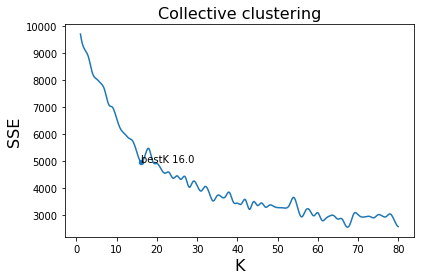

Done


In [10]:
individual_footprint="%s.individual_footprint" %(file)
individual_clusters="%s.clusters" %(individual_footprint)
collective_clusters="%s.collective_footprint.clusters" %(file)
collective_labels="%s.collective_footprint.labels" %(file)
    
f=open(individual_clusters)   #  uid,cluster_id,profile
f.readline()                  #  Saltamos una linea

data=[]
for row in f:
    row=row.strip().split(';')
    uid=row[0]
    cluster_id=row[1]
    individual_profile=np.array([float(el) for el in row[2:]])
    data.append(((uid,cluster_id),individual_profile))

to_cluster=[el[1] for el in data]
    
if len(to_cluster) >= 80:
    tests=np.arange(1,80+1)
else:
    tests=np.arange(1,len(to_cluster)+1)
# tests=list(tests)+list(np.arange(50,150,5))
K=process_footprint(to_cluster,tests,log=True)
# K=process_footprint(to_cluster,np.arange(1,len(to_cluster)+1),log=True)

import pickle
# pickle.dump( K, open( "%s.models.p" %(file), "wb" ) )
    
# Choose K for global clustering 
%matplotlib inline
x=sorted(K.keys())
y=[K[k]['inertia'] for k in x]
best_k,pylab=compute_best_k(x,y,len(to_cluster),plot=True,points=500)

print(best_k)
#best_k=18 #a mano
plt.title("Collective clustering",fontsize=16)
plt.ylabel("SSE",fontsize=16)
plt.xlabel("K",fontsize=16)
plt.tight_layout()
plt.show()
# pylab.savefig('%s.png' %(raw_data),dpi=200)

import pandas as pd
df_sse=pd.DataFrame([x,y]).T
df_sse.columns=['x','y']
#df_sse.to_csv('%s.png.sse.csv' %(raw_data),index=False)
    
    
# EXPORTANDO RESULTADOS
cluster_centers_=K[best_k]['estimator'].cluster_centers_
labels_=K[best_k]['estimator'].labels_
fw=open(collective_clusters,"w")
fw2=open(collective_labels,"w")
fw.write('collective_cluster'+title)
fw2.write('customer_tag;individual_cluster;collective_cluster'+title)

#export individual centroids
for j in np.arange(len(cluster_centers_)):
    string="%s;%s\n"%(j,';'.join([str(el) for el in cluster_centers_[j]])) #cluster_id,centroid
    fw.write(string)
fw.flush()

#export original data and labels
for j in np.arange(len(data)):
    uid=data[j][0]
    profile=data[j][1]
    label=labels_[j]
    string="%s;%s;%s;%s\n" %(uid[0],uid[1],label
                                    ,';'.join([str(el) for el in profile]))#uid,individual_cluster_id,collective_cluster_id,profile
    fw2.write(string)
fw2.flush()

print('Done')